Test code to examine Lake Catchment Areas

In [1]:
#from __future__ import print_function

from collections import OrderedDict
import pandas as pd
import osgeo.ogr
import ECCO_functions_v2 as ECCO
import sys, time, os, json, glob
import numpy as np
import pyproj

import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
def Reproj_Catchment(lake_feature,chatty=False):
    '''
    Takes the lowest level data from the Catchment shape file feature, and
    reprojects the coordinate system using PROJ (PyProj) to a WGS85 system.
    '''
    p1 = pyproj.Proj("+init=EPSG:25833")   # Projected system for lake catchments
    p2 = pyproj.Proj("+init=EPSG:4326")    # World Geodetic system
    tmp1=[]
    
    if lake_feature['geometry']['type'] == 'MultiPolygon':
        if chatty == True: print 'Multi-polygon type'
        for n in lake_feature['geometry']['coordinates'][0][0]:  #For every vertice pair...
            x,y=(pyproj.transform(p1,p2,n[0],n[1],z=None,radians=False)) # trans. coords. to WGS85
            tmp1.append([x,y])
        return tmp1
    else:
        if chatty == True: print 'Simple Polygon type'
        for n in lake_feature['geometry']['coordinates'][0]:  #For every vertice pair...
            x,y=(pyproj.transform(p1,p2,n[0],n[1],z=None,radians=False)) # trans. coords. to WGS85
            tmp1.append([x,y])
        return tmp1

Multi-polygon type


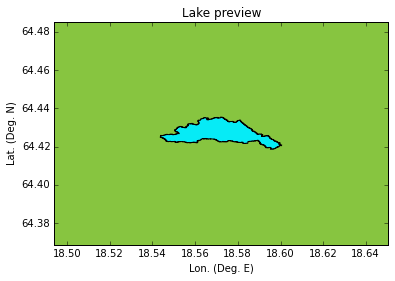

e527b
Area in km^2: 2.32 , No. xy bound. points: 828


In [89]:
input_file = 'Catchments/ecco_biwa_catchments_part_1.shp'

n = 8

ShapeData = osgeo.ogr.Open(input_file)                  # Make a link to Lake Shape Files
TheLayer = ShapeData.GetLayer(iLayer=0)
feature1 = TheLayer.GetFeature(n)                      # Get individ. lake in shapefile
lake_feature = feature1.ExportToJson(as_object=True)
EB_id = hex(int(lake_feature['properties']['ebint']))[2:]


wgs85_xy = Reproj_Catchment(lake_feature=lake_feature,chatty=True)
lake_cart = ECCO.Path_LkIsl_ShpFile([wgs85_xy])
lake_rprj = ECCO.Path_Reproj(lake_cart,False)    # Reproj. lake to CORDEX plr. rotated

ECCO.Preview_Lake(lake_cart)        
print EB_id
print 'Area in km^2:', ECCO.Area_Lake_and_Islands(lake_cart),         
print ', No. xy bound. points:',len(lake_cart.vertices)


In [79]:
#lake_feature
lake_feature['geometry']['coordinates'][0]
p1 = pyproj.Proj("+init=EPSG:25833")   # Projected system for lake catchments
p2 = pyproj.Proj("+init=EPSG:4326")    # World Geodetic system
tmp1=[]
print np.shape(lake_feature['geometry']['coordinates'])
for i,n in enumerate(lake_feature['geometry']['coordinates'][0]):  #For every vertice pair...
    x,y=(pyproj.transform(p1,p2,n[0],n[1],z=None,radians=False)) # trans. coords. to WGS85
    tmp1.append([x,y])
    
print lake_feature['geometry']['type'] == 'MultiPolygon'

(2, 1)
True


In [4]:
input_file = 'Catchments/ecco_biwa_catchments_part_3.shp'
ShapeData = osgeo.ogr.Open(input_file)                  # Make a link to Lake Shape Files
TheLayer = ShapeData.GetLayer(iLayer=0)

TheLayer.GetFeatureCount()
print(np.sum([91268, 91457, 92066]))

274791


In [165]:
def Catchment_Process(nc_path, outputprefix,tt=None,plots = False,rprt=False,sbar=False,
                       rprt_loop=False,gen_meta=False):
    
    # 1. LOADING Climate DATA SECTION and create output file
    if rprt == True:
        atime = clock.time()
    
    clim_dat,rlat,rlon,timeCDX,metadata,txtfname = ECCO.Read_CORDEX_V2(nc_path) # CORDEX NetCDF Read file
    vname, m1, m2, dexp, m3, m4, m5, m6, drange_orignial = metadata        # Metadata of fname string
    var_type = clim_dat.standard_name                                      # What kind of CORDEX data?
    dat_loaded = clim_dat[:,:,:]                                           # Load CORDEX data into RAM
    rlat_loaded = rlat[:]
    rlon_loaded = rlon[:]
    
    #thefilename = 'Catchment_'+str.split(nc_path,'/')[-1][:-3] 
    #FILE= outputprefix + thefilename +'.h5'                # Set up HDF5 file output
    #if os.path.isfile(FILE) == True:
    #    print 'File already exists: Overwriting...'
    #    os.remove(FILE)
    #else:
    #    print 'Creating file: ',FILE
    #f = h5py.File(FILE,'w')
    #-------------------------
    
    # Read it back...
    #atest = pd.read_csv('Catchments/Meta_test.csv')
    #atest = atest.set_index('eb_id')
    
    #lk_processed_inf = pd.read_csv('Metadata/Meta_Lakes.csv')  # Pre-processed lake metadata (CSV)
    #lk_processed_inf.index = lk_processed_inf.hex              # Use the hex-code column as the index 
    
    #c_shapes=[] # put a fixed list of cathcment shapes with relative folder path 'Data/'?
    
    
    lake_file='Catchments/ecco_biwa_catchments_part_1.shp'  # just for testing...
    ShapeData = osgeo.ogr.Open(lake_file)                  # Connection to catchment shapes
    TheLayer = ShapeData.GetLayer(iLayer=0)
    
    #precalculated = []                                     # Gather precalculated surface weights 
    #for fnm in glob.glob("Metadata/Weights/*.npy"):           # N.b. You can precalculate as many as you
    #    precalculated.append(fnm[14:-4])                   # like: place in folder to run (for speed)
    #precalculated = np.array(precalculated)                # Make it a np.array (needed for functions)
    
#----------------------------------------------------------------------
    # 2. Execute code over each catchment area
    if rprt == True:
        btime = clock.time()
    if sbar ==True:
        icnt = 0
    
    for n in range(7,9):
    #for n in dolakes:
        print n
        tlist = []
        feature1 = TheLayer.GetFeature(n)                        # Get catchtment data
        lake_feature = feature1.ExportToJson(as_object=True)     # Convert to JSON
        EB_id = hex(int(lake_feature['properties']['ebint']))[2:]# Extract id number
        wgs85_xy = Reproj_Catchment(lake_feature=lake_feature,
                                   chatty=True)                  # Convert to WGS system
        lake_cart = ECCO.Path_LkIsl_ShpFile([wgs85_xy])          # Create shape object
        lake_rprj = ECCO.Path_Reproj(lake_cart,False)            # Reproj 2 Plr rotated
        
        # MAYBE REPLACE THIS CODE...
        #if EB_id != lk_processed_inf.index[n]:                   # Error check
        #    print 'Warning! Lake feature and metadata miss-match for some reason. Check it out:'
        #    print 'Problem at:',num,lk_processed_inf.num[n],EB_id[2:],lk_processed_inf.index[n]
        if plots == True:     
            ECCO.Preview_Lake(lake_cart)        
            print 'Area in km^2 (not inc. islands):',ECCO.Area_Lake_and_Islands(lake_poly=lake_cart)         
            print ', No. xy bound. points:',len(lake_cart.vertices)
        
        
        sub_clim,sub_rlat,sub_rlon = ECCO.TrimToLake(lake_in=lake_rprj,Cdat=dat_loaded[0,:,:],
                                                     rlat=rlat_loaded,rlon=rlon_loaded,
                                                     off = 3, show = True) 
        
        weight_mask = ECCO.Pixel_Weights(lake_in=lake_rprj,datin=sub_clim,
                                         lat_atts=sub_rlat,lon_atts=sub_rlon)
        
        # For making the surface-weights saved .npy arrays, 
        # and extracting metadata (pixel counts and xy)
        if gen_meta == True:
            pix_truth = (weight_mask > 0.0)    # Count how many times the weight mask is
            pxnum = len(weight_mask[pix_truth])  #  above 0.0 (i.e. how many pixels of data are needed)
            print 'how many pixels?',pxnum
            ypix = -99
            xpix = -99
            if pxnum == 1:
                xxx,yyy = ECCO.Get_LatLonLim(xypath=lake_rprj.vertices)  # Find upp./low.lake lims.
                ypix = (ECCO.Closest(array=rlat,value=yyy[0]))                # For lakes of one pixel  
                xpix = (ECCO.Closest(array=rlon,value=xxx[0]))
                print 'one pixel (x,y):',xpix,ypix
            if pxnum < 1:
                pxnum = 1  # Small bug where it thinks lakes dont exist, no biggy...
            #if pxnum > 1:
                #np.save('Lakes/Weights/'+EB_id[2:],weight_mask)
        
        
            #return num,EB_id[2:], Area_Lake_and_Islands(lake_cart),pxnum,etime,ypix,xpix
            plt.imshow(weight_mask,interpolation='none',alpha=None,cmap=plt.cm.gray)
        
        '''
        #<<<< NEED TO CREATE DATABASE OF LAKE CATCHMENT METADATA, and WORK OUT ORDER
        # TO READ IN ALL THE SHAPE DATA FROM ALL THE FILES...
        
        if lk_processed_inf.npix[EB_id] == 1:         # ONE PIXEL LAKES <<<
            ypix = lk_processed_inf.ypix[EB_id]       # Get the pre-calc. pixel indexes...
            xpix = lk_processed_inf.xpix[EB_id]       # ...calc in MT_Gen_SWeights() earlier
            if lake_altitude == None:                 # Some lakes don't have alitude values
                offset = -999.
        else:                                         # LAKES OF MORE THAN ONE PIXEL <<<
            pre_test = (lk_processed_inf.hex[EB_id] == precalculated)
            if(any(pre_test) == True):                # Scipy's any() evalautes list truth
                weightfile = 'Metadata/Weights/'+precalculated[pre_test][0]+'.npy'
                weight_mask = np.load(weightfile)
            else:           # If no pre-calculated weight mask file then calculate it now
                sub_clim,sub_rlat,sub_rlon = TrimToLake(lake_rprj,dat_loaded[0,:,:],rlat_loaded,
                                                        rlon_loaded,off = 3, show = False) 
                weight_mask = Pixel_Weights(lake_rprj,sub_clim,sub_rlat,sub_rlon)

            
            sub_clim,sub_rlat,sub_rlon = TrimToLake3D(lake_rprj,dat_loaded,rlat_loaded,rlon_loaded,
                                                      off = 3, show = False)
            
            tlist = Weighted_Mean_3D(weight_mask, sub_clim, chatty=False)  # Here's the t-series
            tlist = np.squeeze(tlist)                                      # Remove empty dimension
            
            if plots == True:
                Show_LakeAndData(lake_rprj,dat_loaded[0,:,:],rlat,rlon,zoom=6.)
                Preview_Weights(lake_rprj,weight_mask,sub_rlat,sub_rlon) 
                
        if rprt_loop ==True:
            print '\rStats:',(float(n)/float(lstop))*100.,'% ',n,EB_id,offset,lake_altitude,
        if sbar ==True:
            icnt=icnt+1
            if (float(icnt) % 10.) == 0.0:
                Update_Progress(float(icnt)/float(len(dolakes)-1))

        Write_HDF(f,EB_id,tlist,offset,lk_processed_inf.area[n])  # Write inside function
        feature1=0
        lake_feature = 0

    f.close()                                # Close the HDF5 file after the lake loop finishes
    subprocess.call(["gzip", FILE])             # Compress the file and remove original with gzip             
    if rprt == True:
        ctime = clock.time()
    #-------------------------------------------------------------------------------------------
    # 3. Finish and report time if requested
    if rprt == True:
            print '\nTime to read data: %4.2f sec'%(btime - atime)
            print 'Time to Process %i lakes: %4.2f sec'%(len(dolakes),ctime - btime)
    '''
    return

In [172]:
nc_path ='CORDEX/tas_EUR-11_ICHEC-EC-EARTH_rcp45_r1i1p1_KNMI-RACMO22E_v1_day_20960101-21001231.nc'
lake_file ='Catchments/ecco_biwa_catchments_part_1.shp'

#Catchment_Process(nc_path=nc_path, outputprefix=None,plots = True,rprt=False,sbar=False,
#                       rprt_loop=False,gen_meta=True)

Catchment_Weights_Meta(nc_path=nc_path)

Catchments/ecco_biwa_catchments_part_1.shp
91268
Simple Polygon type
d30b2 1.2 2 -99 -99
Simple Polygon type
d47c6 1.61 1 310 233
Simple Polygon type
d4bd1 2.19 2 -99 -99
Simple Polygon type
d5a60 0.57 2 -99 -99
Simple Polygon type
d730e 0.62 1 396 275
Simple Polygon type
dc03a 8.24 1 286 207
Simple Polygon type
e3cbf 0.02 1 371 262
Simple Polygon type
e347e 0.15 1 285 229
Multi-polygon type
e527b 2.32 2 -99 -99
Simple Polygon type
e63bb 0.06 1 345 264
Catchments/ecco_biwa_catchments_part_2.shp
91457
Simple Polygon type
555cd0 0.07 1 333 232
Simple Polygon type
5588ef 0.19 1 330 243
Multi-polygon type
55a0d0 73.61 5 -99 -99
Multi-polygon type
55cdec 6.65 1 385 295
Simple Polygon type
56422f 0.39 1 325 286
Simple Polygon type
567155 59.79 3 -99 -99
Simple Polygon type
569cad 0.05 1 332 219
Simple Polygon type
56d57c 0.11 2 -99 -99
Simple Polygon type
56bebc 0.08 1 341 244
Simple Polygon type
56c44f 1.31 1 349 295
Catchments/ecco_biwa_catchments_part_3.shp
92066
Simple Polygon type
aab15

In [121]:
# Save it out...
#meta_test.to_csv('Catchments/Meta_test.csv',index=False)
# Read it back...
#atest = pd.read_csv('Catchments/Meta_test.csv')
#atest = atest.set_index('eb_id')

In [170]:
# Find every catchment shape file, also find the number of features inside it

catchflist = []                                     # Gather precalculated surface weights 
for fnm in glob.glob("Catchments/*.shp"):           # N.b. You can precalculate as many as you
    catchflist.append(fnm)
    print(fnm)
    ShapeData = osgeo.ogr.Open(fnm)                  # Make a link to Lake Shape Files
    TheLayer = ShapeData.GetLayer(iLayer=0)
    print(TheLayer.GetFeatureCount())
    dolakes=range(TheLayer.GetFeatureCount())   # Create a range to loop over lake features   


Catchments/ecco_biwa_catchments_part_1.shp
91268
Catchments/ecco_biwa_catchments_part_2.shp
91457
Catchments/ecco_biwa_catchments_part_3.shp
92066


In [171]:
def Catchment_Weights_Meta(nc_path):
    '''
    From catchment data, generate surface weights if requested, and meta
    data files also.
    '''
    # 1. LOAD Climate DATA
    clim_dat,rlat,rlon,timeCDX,metadata,txtfname = ECCO.Read_CORDEX_V2(nc_path) # CORDEX NetCDF Read file
    vname, m1, m2, dexp, m3, m4, m5, m6, drange_orignial = metadata        # Metadata of fname string
    var_type = clim_dat.standard_name                                      # What kind of CORDEX data?
    dat_loaded = clim_dat[:,:,:]                                           # Load CORDEX data into RAM
    rlat_loaded = rlat[:]
    rlon_loaded = rlon[:]
    
    #lake_file='Catchments/ecco_biwa_catchments_part_1.shp'  # just for testing...
    #ShapeData = osgeo.ogr.Open(lake_file)                  # Connection to catchment shapes
    #TheLayer = ShapeData.GetLayer(iLayer=0)
    tmp_meta = []  # list to hold what will become the metadat dataframe values
    # 2. Execute code over each catchment area
    
    # For the three catchment files - loop over each file and do every feature element...
    catchflist = []                                     # Gather precalculated surface weights 
    for fnm in glob.glob("Catchments/*.shp"):           # N.b. You can precalculate as many as you
        catchflist.append(fnm)
        print(fnm)
        ShapeData = osgeo.ogr.Open(fnm)                  # Make a link to Lake Shape Files
        TheLayer = ShapeData.GetLayer(iLayer=0)
        print(TheLayer.GetFeatureCount())
        dolakes=range(TheLayer.GetFeatureCount())   # Create a range to loop over lake features   
     
    #for n in range(0,30):
        for n in dolakes[0:10]:
            tlist = []
            feature1 = TheLayer.GetFeature(n)                        # Get catchtment data
            lake_feature = feature1.ExportToJson(as_object=True)     # Convert to JSON
            EB_id = hex(int(lake_feature['properties']['ebint']))[2:]# Extract id number
            wgs85_xy = Reproj_Catchment(lake_feature=lake_feature,
                                       chatty=True)   # Convert to WGS system
            lake_cart = ECCO.Path_LkIsl_ShpFile([wgs85_xy])          # Create shape object
            lake_rprj = ECCO.Path_Reproj(lake_cart,False)            # Reproj 2 Plr rotated
        
            sub_clim,sub_rlat,sub_rlon = ECCO.TrimToLake(lake_in=lake_rprj,Cdat=dat_loaded[0,:,:],
                                                         rlat=rlat_loaded,rlon=rlon_loaded,
                                                         off = 3, show = False) 
        
            weight_mask = ECCO.Pixel_Weights(lake_in=lake_rprj,datin=sub_clim,
                                             lat_atts=sub_rlat,lon_atts=sub_rlon)
        
            # For making the surface-weights saved .npy arrays and metadata (pixel counts and xy)
            pix_truth = (weight_mask > 0.0)    # Count how many times the weight mask is
            pxnum = len(weight_mask[pix_truth])  #  above 0.0 (i.e. how many pixels of data are needed)
        
            if pxnum > 1:
                np.save('Catchments/Weights/'+EB_id,weight_mask)
                ypix = -99
                xpix = -99

            if pxnum < 1:
                pxnum = 1                                               # Small bug fix, no biggy...
            if pxnum == 1:
                xxx,yyy = ECCO.Get_LatLonLim(xypath=lake_rprj.vertices)  # Find upp./low.lake lims.
                ypix = (ECCO.Closest(array=rlat,value=yyy[0]))                # For lakes of one pixel  
                xpix = (ECCO.Closest(array=rlon,value=xxx[0]))
                #print 'one pixel (x,y):',xpix,ypix
            print EB_id, ECCO.Area_Lake_and_Islands(lake_poly=lake_cart),pxnum,ypix,xpix
            tmp_meta.append([EB_id, ECCO.Area_Lake_and_Islands(lake_poly=lake_cart),pxnum,ypix,xpix])

    meta = pd.DataFrame(data = tmp_meta,columns=['eb_id','area','npix','ypix','xpix'])
    meta.to_csv('Catchments/Metadata/Meta_Catchments.csv',index=False)
    return